### The partial derivatives should be computed simultaneously
So that they can be consistent.

In [1]:
from sklearn import datasets
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
iris = datasets.load_iris()
#X = iris["data"][:,3:]  # petal width
X = iris["data"][:,:]
y = (iris["target"]==2).astype(np.int)
X.shape, y.shape

((150, 4), (150,))

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((108, 4), (27, 4), (15, 4))

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
def binary_loss(X, Y, weights, alpha=0.00001):
    """
    X.shape = (num_instances, num_features)
    Y.shape = (num_instances,)
    weights.shape = (num_features,)
    """
    epsilon = 1e-5
    z = np.dot(X, weights)
    h = sigmoid(z)
    total_cost = (-Y*np.log(h+epsilon) - (1-Y)*np.log(1-h + epsilon)).mean() + alpha * np.sum(np.dot(weights, weights.T))
    return total_cost

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

**(?)** Why `StandardScaler()` performs bad here?

In [7]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], alpha=0.0001, epochs=5, tolerance=0.0001, print_progress=True):
    def learning_schedule(t):
        epsilon = 1e-5
        return 1 / (t * alpha + epsilon)
    def glorot_init(n_features):
        fan_avg = (n_features + 1) / 2
        var = 1 / fan_avg
        r = np.sqrt(3*var)
        return np.random.uniform(low=-r, high=r, size=(n_features))
    train_loss_history, val_loss_history = [], []
    num_features = X_tr.shape[1]
    #weights = np.zeros(shape=(num_features,))
    #weights = np.zeros(shape=(num_features,), dtype=np.float64)
    #weights = np.random.randn(num_features)
    weights = glorot_init(num_features)
    #clip_value = 1e-9
    #X_tr = np.clip(X_tr, clip_value, 1-clip_value)
    mms = MinMaxScaler()
    #mms = StandardScaler()
    X_tr = mms.fit_transform(X_tr)
    best_val_loss = np.inf
    for epoch in range(epochs):
        indices = np.arange(X_tr.shape[0])
        np.random.shuffle(indices)
        X_tr = X_tr[indices]
        Y_tr = Y_tr[indices]

        # training loop
        train_loss = 0
        for idx, row in enumerate(X_tr):
            row = np.reshape(row, (1, num_features))
            train_loss += binary_loss(row, Y_tr[idx], weights, alpha)
            eta = learning_schedule(epoch*len(X_tr) + idx + 1)
            #for i in range(len(row)):
            #    #gradient = (sigmoid(row @ weights) - float(Y_tr[idx])) * row[0, i] + alpha*weights[i]*2
            #    gradient = (sigmoid(row @ weights) - Y_tr[idx]) * row[0, i] + alpha*weights[i]*2
            #    weights[i] -= gradient*eta
            gradient = (sigmoid(row @ weights) - Y_tr[idx]) * row[0] + 2*alpha*weights
            weights -= eta*gradient
        train_loss /= X_tr.shape[0]
        train_loss_history.append(train_loss)

        if len(X_dev) != 0 and len(Y_dev) != 0:
            X_dev = mms.transform(X_dev)
            val_loss = binary_loss(X_dev, Y_dev, weights, alpha)
            val_loss_history.append(val_loss)

            if print_progress:
                print(f"Epoch: {epoch+1}")
                print(f"Training loss:   {train_loss:.4f}")
                print(f"Validation loss: {val_loss:.4f}")

            # Wang seems to want the training process to stop when the progress becomes no longer significant.
            #if epoch >=1:
            #    if np.abs(val_loss_history[epoch]-val_loss_history[epoch-1]) < tolerance:
            #        break
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = weights
                print(f"best epoch {epoch}")

    return best_weights, train_loss_history, val_loss_history

In [52]:
n_epochs = 100
w, train_hist, val_hist = SGD(X_train, y_train, X_dev=X_val, Y_dev=y_val, epochs=n_epochs, print_progress=False)

/home/phunc20/.config/miniconda3/envs/homl-1e/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


best epoch 0
best epoch 1
best epoch 5


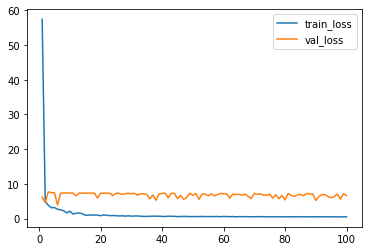

In [53]:
x = range(1, len(train_hist)+1)
plt.plot(x, train_hist, label="train_loss")
plt.plot(x, val_hist, label="val_loss")
plt.legend();

In [54]:
y_train_pred = (sigmoid(X_train @ w) > 0.5).astype(np.int)
y_train_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
confusion_matrix(y_train, y_train_pred)

array([[71,  0],
       [37,  0]])

In [56]:
y_val_pred = (sigmoid(X_val @ w) > 0.5).astype(np.int)
y_val_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [57]:
confusion_matrix(y_val, y_val_pred)

array([[17,  0],
       [10,  0]])

In [58]:
y_test_pred = (sigmoid(X_test @ w) > 0.5).astype(np.int)
y_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [59]:
confusion_matrix(y_test, y_test_pred)

array([[12,  0],
       [ 3,  0]])

### Let's try to train with `LogisticRegression`

In [60]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
y_train_pred = log_reg.predict(X_train)
confusion_matrix(y_train, y_train_pred)

array([[69,  2],
       [ 1, 36]])

In [19]:
y_val_pred = log_reg.predict(X_val)
confusion_matrix(y_val, y_val_pred)

array([[17,  0],
       [ 0, 10]])

In [20]:
y_test_pred = log_reg.predict(X_test)
confusion_matrix(y_test, y_test_pred)

array([[12,  0],
       [ 0,  3]])

### With `SGDClassifier`
Let's try with [`sklearn.linear_model.SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) to see how good it can be.

In [21]:
from sklearn.linear_model import SGDClassifier

In [22]:
clf = SGDClassifier(loss="log")
clf.fit(X_train, y_train)

SGDClassifier(loss='log')

In [23]:
y_train_pred = clf.predict(X_train)
confusion_matrix(y_train, y_train_pred)

array([[38, 33],
       [ 0, 37]])

In [24]:
y_test_pred = clf.predict(X_test)
confusion_matrix(y_test, y_test_pred)

array([[6, 6],
       [0, 3]])

In [25]:
y_val_pred = clf.predict(X_val)
confusion_matrix(y_val, y_val_pred)

array([[ 8,  9],
       [ 0, 10]])

### A different learning schedule

In [26]:
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

In [27]:
def SGD_ageron(X_tr, Y_tr, X_dev=[], Y_dev=[], alpha=0.0001, epochs=5, tolerance=0.0001, print_progress=True):
    train_loss_history, val_loss_history = [], []
    num_features = X_tr.shape[1]
    #weights = np.zeros(shape=(num_features,), dtype=np.float64)
    weights = np.random.randn(num_features)
    #clip_value = 1e-9
    #X_tr = np.clip(X_tr, clip_value, 1-clip_value)
    mms = MinMaxScaler()
    #mms = StandardScaler()
    X_tr = mms.fit_transform(X_tr)
    best_val_loss = np.inf
    for epoch in range(epochs):
        indices = np.arange(X_tr.shape[0])
        np.random.shuffle(indices)
        X_tr = X_tr[indices]
        Y_tr = Y_tr[indices]

        # training loop
        train_loss = 0
        for idx, row in enumerate(X_tr):
            row = np.reshape(row, (1, num_features))
            train_loss += binary_loss(row, Y_tr[idx], weights, alpha)
            eta = learning_schedule(epoch*len(X_tr)  + idx)
            #for i in range(len(row)):
            #    gradient = (sigmoid(row @ weights) - float(Y_tr[idx])) * row[0, i] + alpha*weights[i]*2
            #    #weights[i] -= gradient*eta
            gradient = (sigmoid(row @ weights) - Y_tr[idx]) * row[0] + 2*alpha*weights
            weights -= eta*gradient
        train_loss /= X_tr.shape[0]
        train_loss_history.append(train_loss)

        if len(X_dev) != 0 and len(Y_dev) != 0:
            X_dev = mms.transform(X_dev)
            val_loss = binary_loss(X_dev, Y_dev, weights, alpha)
            val_loss_history.append(val_loss)

            if print_progress:
                print(f"Epoch: {epoch+1}")
                print(f"Training loss:   {train_loss:.4f}")
                print(f"Validation loss: {val_loss:.4f}")

            # Wang seems to want the training process to stop when the progress becomes no longer significant.
            #if epoch >=1:
            #    if np.abs(val_loss_history[epoch]-val_loss_history[epoch-1]) < tolerance:
            #        break
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = weights
                print(f"best epoch {epoch}")

    return best_weights, train_loss_history, val_loss_history

In [28]:
w, train_hist, val_hist = SGD_ageron(X_train, y_train, X_dev=X_val, Y_dev=y_val, epochs=n_epochs, print_progress=False)
#w, train_hist, val_hist = SGD_ageron(X_train, y_train, X_dev=X_val, Y_dev=y_val, epochs=n_epochs, print_progress=False, alpha=0)

best epoch 0


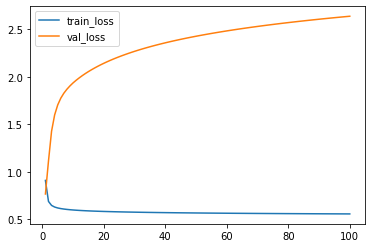

In [29]:
x = range(1, len(train_hist)+1)
plt.plot(x, train_hist, label="train_loss")
plt.plot(x, val_hist, label="val_loss")
plt.legend();

In [30]:
y_train_pred = (sigmoid(X_train @ w) > 0.5).astype(np.int)
y_train_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [31]:
confusion_matrix(y_train, y_train_pred)

array([[71,  0],
       [37,  0]])

In [32]:
y_val_pred = (sigmoid(X_val @ w) > 0.5).astype(np.int)
y_val_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [33]:
confusion_matrix(y_val, y_val_pred)

array([[17,  0],
       [10,  0]])

In [34]:
y_test_pred = (sigmoid(X_test @ w) > 0.5).astype(np.int)
y_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
confusion_matrix(y_test, y_test_pred)

array([[12,  0],
       [ 3,  0]])